<a href="https://colab.research.google.com/github/georgeo30/AVL-VS-BST/blob/master/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#Mounting from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
#Dataset class that will be used to get an image and its label at a time using the gpu to save memory
#imports for this class
from torch.utils import data
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class Dataset(data.Dataset):
    #constructor
    def __init__(self, list_IDs, labels, image_transform = None,label_transform = None ):
        self.labels = labels
        self.list_IDs = list_IDs
        self.image_transform = image_transform
        self.label_transform = label_transform

    #denotes the total number of samples    
    def __len__(self):
        return len(self.list_IDs)

    #generates one sample of the data while performing the transforms required
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        X, y = self.__data_generation(ID)

        return X, y
    #method used to perform the transforms on the image
    def __data_generation(self, ID): 
    
        # Read images using scikit-image io library
        #check if img is from superimposed or natural images
        belong_to_folder=ID[:1]
        if (belong_to_folder=="T"):
          X = io.imread('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Test/'+ID)
        elif (belong_to_folder=="V"):
          X = io.imread('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Valid/'+ID)
        else:
          X = io.imread('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Train/'+ID)

        
        # Store class label
        returned_path = self.labels[ID]
        returned_labels=io.imread(returned_path, as_gray=True)
        # check the min and max here and force to be binary (0 OR 1)
        # then you would not need to threshold at a later stage - Shane

        #print("Returned labels shape1: ",returned_labels.shape)
        #m,n = returned_labels.shape
        #print(m,n)
        #returned_labels=returned_labels.reshape((m,n,1))
        returned_labels = Image.fromarray(returned_labels)
       
        X = np.repeat(X[:, :, np.newaxis], 3, axis=2)
        X = Image.fromarray(X, mode = 'RGB')
        

        if self.image_transform is not None:
            # Transform works on PIL images and should return PyTorch tensor
            X = self.image_transform(X)
        if self.label_transform is not None:
            # Transform works on PIL images and should return PyTorch tensor
            returned_labels=self.label_transform(returned_labels)
        #print("X shape: ",X.shape)
        l=torch.reshape(returned_labels,(1,224,224))
        l[l >= 0.5]=1
        l[l < 0.5]=0


        
        return X,l

In [26]:
#imports for training
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F


In [27]:
transform = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_labels = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor()])

In [28]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda)

True


In [29]:
import os

partition={"train":[],"valid":[],"test":[]}
labels={}

partition['train']=os.listdir('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Train')
partition['valid']=os.listdir('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Valid')
partition['test']=os.listdir('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Test')
for train in partition['train']:
  labels[train]='gdrive/My Drive/VASTECH-SSSD/SuperImposedLabels/Train/'+train
for valid in partition['valid']:
  labels[valid]='gdrive/My Drive/VASTECH-SSSD/SuperImposedLabels/Valid/'+valid
for test in partition['test']:
  labels[test]='gdrive/My Drive/VASTECH-SSSD/SuperImposedLabels/Test/'+test

print(partition)
print(labels)

{'train': ['2999.png', '2996.png', '3003.png', '2994.png', '3009.png', '3005.png', '3004.png', '3010.png', '3006.png', '3018.png', '3011.png', '3008.png', '3019.png', '3013.png', '3012.png', '3007.png', '3015.png', '3017.png', '3014.png', '3016.png', '3022.png', '3021.png', '3029.png', '3026.png', '3027.png', '3032.png', '3025.png', '3020.png', '3030.png', '3024.png', '3028.png', '3031.png', '3023.png', '3036.png', '3043.png', '3038.png', '3046.png', '3044.png', '3035.png', '3033.png', '3045.png', '3042.png', '3034.png', '3037.png', '3040.png', '3041.png', '3039.png', '3050.png', '3056.png', '3052.png', '3055.png', '3059.png', '3048.png', '3051.png', '3047.png', '3058.png', '3057.png', '3049.png', '3053.png', '3054.png', '3071.png', '3064.png', '3069.png', '3062.png', '3063.png', '3060.png', '3066.png', '3072.png', '3070.png', '3065.png', '3067.png', '3068.png', '3061.png', '3074.png', '3081.png', '3082.png', '3073.png', '3083.png', '3080.png', '3077.png', '3075.png', '3085.png', '3084

In [30]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 0

In [31]:
# Generators
#training
training_set = Dataset(partition['train'], labels,transform,transform_labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)
#validation
validation_set = Dataset(partition['valid'], labels,transform,transform_labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)
#testing
testing_set = Dataset(partition['test'], labels,transform,transform_labels)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

tensor([0., 1.])
torch.Size([3, 906, 1810])
Ïmage min -2.117904 Ïamge max 2.64


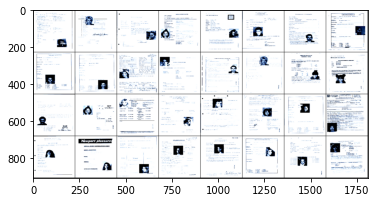

torch.Size([3, 906, 1810])
Ïmage min 0.0 Ïamge max 1.0


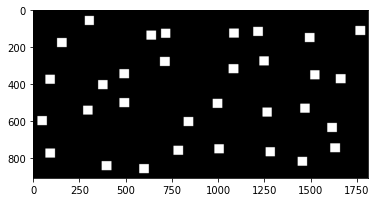

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 1.])
torch.Size([3, 906, 1810])
Ïmage min -2.117904 Ïamge max 2.64


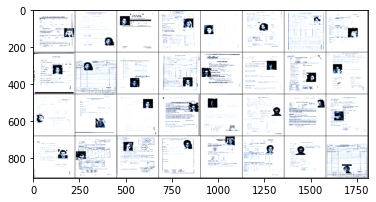

torch.Size([3, 906, 1810])
Ïmage min 0.0 Ïamge max 1.0


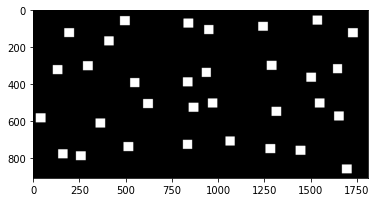

In [32]:
#showing some of the images
import matplotlib.pyplot as plt
import numpy as np

#functions to show an image


def imshow(img,i):
    print(img.shape)
    #img = img / 2 + 0.5     # unnormalize
    # img = img - np.amin(img) # this makes the smallest value 0
    # img = img/np.amax(img) # this makes values go from 0 to 1
    # img = (255*img).astype(np.uint8) # strectch values to 255 and cast to unit8
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print("Ïmage min", np.amin(npimg), "Ïamge max", np.amax(npimg))
    #plt.savefig('gdrive/My Drive/VASTECH-SSSD/batch'+str(i)+'.png')

    plt.show()
i=0
for local_batch, local_labels in training_generator:
  i+=1
  
  print(torch.unique(local_labels))
  imshow(torchvision.utils.make_grid(local_batch),i)
  imshow(torchvision.utils.make_grid(local_labels),i)


  if i==2:

    break;


In [75]:
import torch
from torch import nn

model = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [76]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False
layer= nn.Sequential(
          nn.Conv2d(512,256,kernel_size=(3, 3),stride=(1, 1), padding=(1, 1), bias=False),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.ReLU(),
          nn.Dropout(p=0.1, inplace=False),
          nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)),
        )
model.classifier[4] = layer
#model.classifier[4]=nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))


model.aux_classifier[4]=nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

print(model)

if torch.cuda.is_available():
    model.cuda()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [77]:
import torch.optim as optim
params_to_update = []
print("Params to learn:")
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)
#criterion=nn.MSELoss()
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Params to learn:
	 classifier.4.0.weight
	 classifier.4.1.weight
	 classifier.4.1.bias
	 classifier.4.4.weight
	 classifier.4.4.bias
	 aux_classifier.4.weight
	 aux_classifier.4.bias


In [78]:
def dice_loss(prediction, target):
    """Calculating the dice loss
    Args:
        prediction = predicted image
        target = Targeted image
    Output:
        dice_loss"""

    smooth = 1.0

    i_flat = prediction.view(-1)
    t_flat = target.view(-1)

    intersection = (i_flat * t_flat).sum()

    return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

In [79]:
def calc_loss(prediction, target, bce_weight=0.5):
    """Calculating the loss and metrics
    Args:
        prediction = predicted image
        target = Targeted image
        metrics = Metrics printed
        bce_weight = 0.5 (default)
    Output:
        loss : dice loss of the epoch """
    bce = F.binary_cross_entropy_with_logits(prediction, target)
    prediction = torch.sigmoid(prediction)
    dice = dice_loss(prediction, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss


In [ ]:
#training
from scipy.special import softmax
from sklearn.metrics import jaccard_score
from scipy.special import expit, logit

epochs=10
total_training_score=0
total_validating_score=0
train_count=0
valid_count=0
for epoch in range(epochs):
  model.train()
  valid_loss=0.0
  running_loss=0.0
  training_total=0
  training_correct=0
  valid_total=0
  valid_correct=0
  i=0
  j=0
  print("Training...")
  for local_batch, local_labels in training_generator:
    # Transfer to GPU
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    optimizer.zero_grad()
    outputs=model(local_batch)['out']

    #loss=criterion(outputs,local_labels)
    loss=calc_loss(outputs,local_labels)
    running_loss +=loss.item() * local_batch.size(0)

    loss.backward()
    optimizer.step()



    if i % 32 == 31:
      print('[%d, %3d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 32))
      running_loss = 0.0
      #Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
      
    i+=1
    outputs=outputs.cpu().detach().numpy()
    local_labels=local_labels.cpu().detach().numpy()
    for img in range(len(outputs)):
      imgArr=expit(outputs[img])
      imgmin=np.amin(imgArr)
      imgmax=np.amax(imgArr)
      thresh=imgmin+((imgmax-imgmin)*0.8)
      imgArr[imgArr >= thresh]=1
      imgArr[imgArr < thresh]=0
      outputs[img]=imgArr
    train_batch_score_total=0
    for index_in_batch in range(len(outputs)):
      score=(jaccard_score(outputs[index_in_batch][0],local_labels[index_in_batch][0],average="micro")*100)
      #print(score)
      train_batch_score_total+=score
    batchTrain=train_batch_score_total/len(outputs)
    total_training_score+=batchTrain
    train_count+=1
    #print("Avergae Score for batch Training",train_batch_score_total/params['batch_size'])















  #Validation
  print("Validating...")
  model.eval()
  with torch.set_grad_enabled(False):
    for local_batch, local_labels in validation_generator:
      local_batch, local_labels = local_batch.to(device), local_labels.to(device)

      # Transfer to GPU
      outputs=model(local_batch)['out']
      loss=calc_loss(outputs,local_labels)
      valid_loss += loss.item()

      if j % 32== 31:
        print('[%d, %3d] loss: %.3f' %(epoch + 1, j + 1, valid_loss / 10))

        valid_loss = 0.0
      j+=1

      outputs=outputs.cpu().numpy()
      local_labels=local_labels.cpu().numpy()
      for img in range(len(outputs)):
        imgArr=expit(outputs[img])
        imgmin=np.amin(imgArr)
        imgmax=np.amax(imgArr)
        thresh=imgmin+((imgmax-imgmin)*0.8)
        imgArr[imgArr >= thresh]=1
        imgArr[imgArr < thresh]=0
        outputs[img]=imgArr

      valid_batch_score_total=0
      for index_in_batch in range(len(outputs)):
        score=(jaccard_score(outputs[index_in_batch][0],local_labels[index_in_batch][0],average="micro")*100)
        #print(score)
        valid_batch_score_total+=score
      batchValid=valid_batch_score_total/len(outputs)
      total_validating_score+=batchValid
      valid_count+=1
      #print("Avergae Score for batch Validating",batchValid)
  model.train()

print("Total IOU Score for Training: ",total_training_score/train_count)

print("Total IOU Score for Validating: ",total_validating_score/valid_count)
      

      


Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[1,  32] loss: 11.120
[1,  64] loss: 3.560
[1,  96] loss: 3.005
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[1,  32] loss: 0.277
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[2,  32] loss: 2.648
[2,  64] loss: 2.581
[2,  96] loss: 2.487
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[2,  32] loss: 0.266
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[3,  32] loss: 2.421
[3,  64] loss: 2.426
[3,  96] loss: 2.342
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[3,  32] loss: 0.230
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[4,  32] loss: 2.280
[4,  64] loss: 2.235
[4,  96] loss: 2.254
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[4,  32] loss: 0.220
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[5,  32] loss: 2.185
[5,  64] loss: 2.179
[5,  96] loss: 2.105
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[5,  32] loss: 0.206
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[6,  32] loss: 2.090
[6,  64] loss: 2.093
[6,  96] loss: 2.071
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[6,  32] loss: 0.201
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[7,  32] loss: 2.033
[7,  64] loss: 2.044
[7,  96] loss: 2.007
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[7,  32] loss: 0.197
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[8,  32] loss: 1.959
[8,  64] loss: 2.009
[8,  96] loss: 1.971
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[8,  32] loss: 0.193
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[9,  32] loss: 1.920
[9,  64] loss: 1.944
[9,  96] loss: 1.930
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[9,  32] loss: 0.194
Training...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[10,  32] loss: 1.925
[10,  64] loss: 1.937
[10,  96] loss: 1.862
Validating...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[10,  32] loss: 0.186
Total IOU Score for Training:  80.25203585274879
Total IOU Score for Validating:  82.70289950006989


In [ ]:
PATH = 'gdrive/My Drive/VASTECH-SSSD/semanticsegmentationTwo.pth'
torch.save(model.state_dict(), PATH)

In [81]:
PATH = 'gdrive/My Drive/VASTECH-SSSD/semanticsegmentationTwo.pth'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

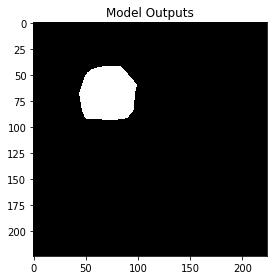

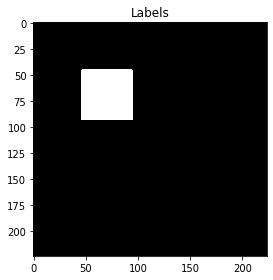

Avergae Score for batch 86.28354104760294


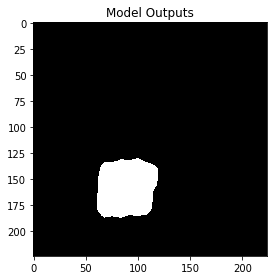

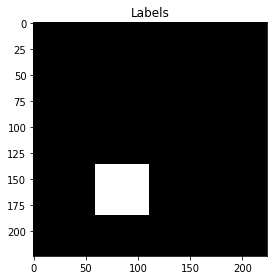

Avergae Score for batch 83.67959535246897


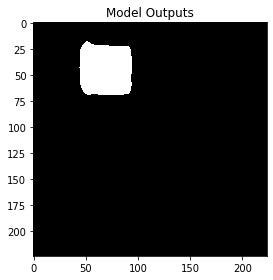

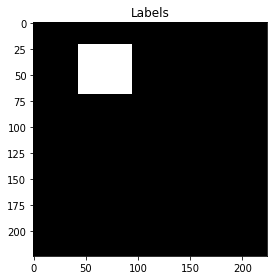

Avergae Score for batch 86.91421612522899


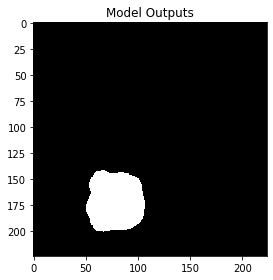

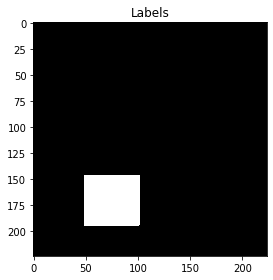

Avergae Score for batch 84.9011818983073


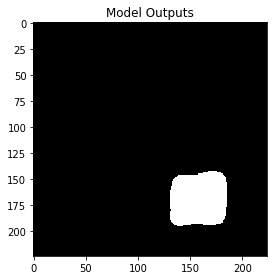

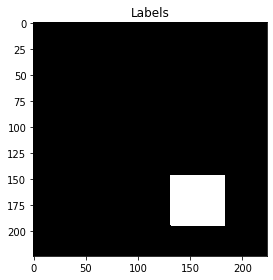

Avergae Score for batch 85.75383846996002


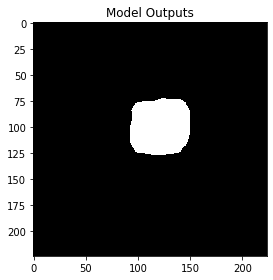

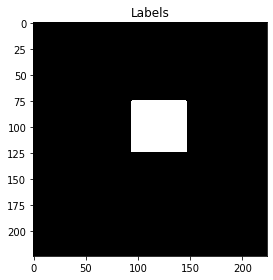

Avergae Score for batch 86.6337816443064


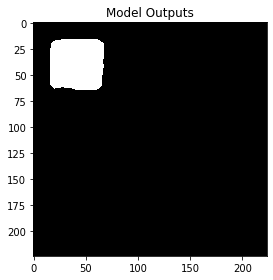

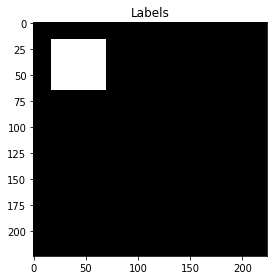

Avergae Score for batch 82.7304496575413


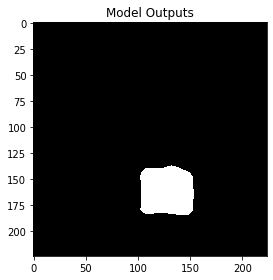

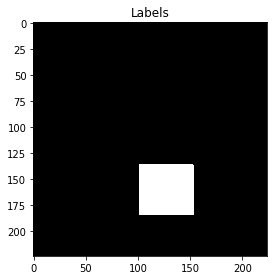

Avergae Score for batch 85.9182911995565


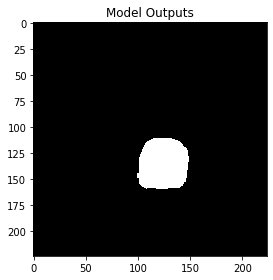

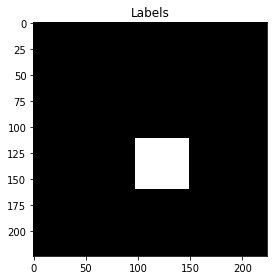

Avergae Score for batch 84.80712299779866


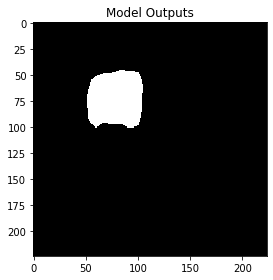

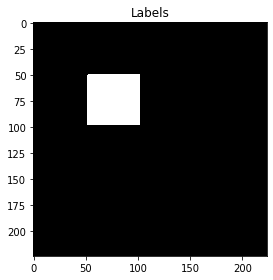

Avergae Score for batch 85.94619842755081


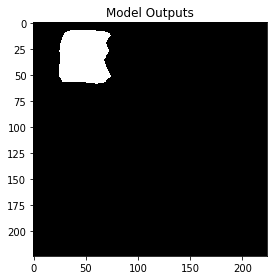

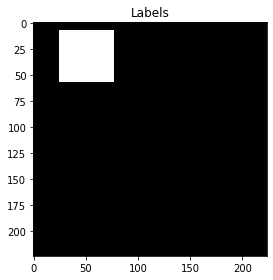

Avergae Score for batch 85.21523319842161


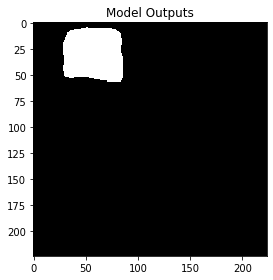

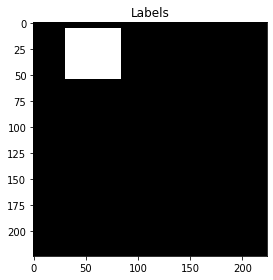

Avergae Score for batch 82.32972253037626


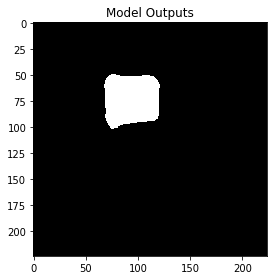

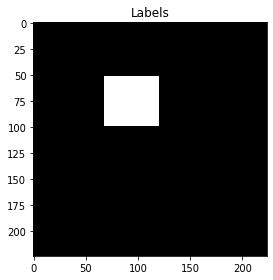

Avergae Score for batch 86.17874409362464


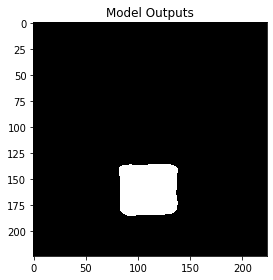

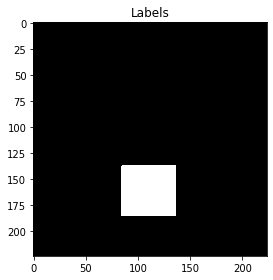

Avergae Score for batch 84.80289267547737


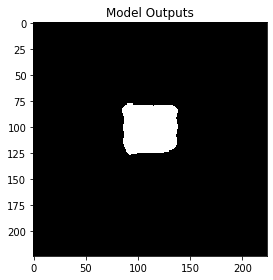

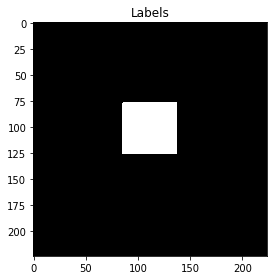

Avergae Score for batch 81.59691633222705


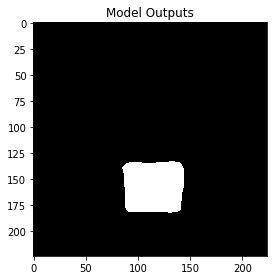

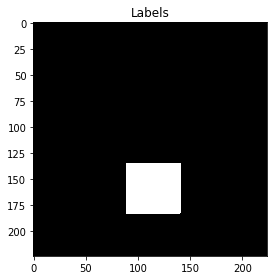

Avergae Score for batch 86.02679259132685


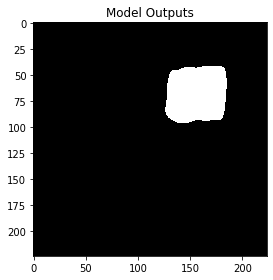

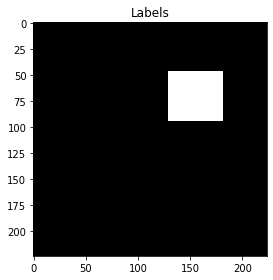

Avergae Score for batch 84.83842718344567


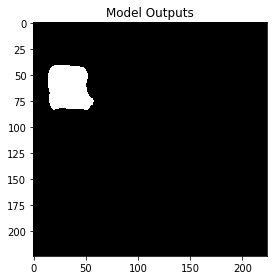

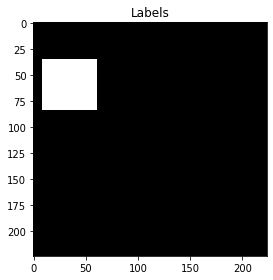

Avergae Score for batch 81.42570208241762


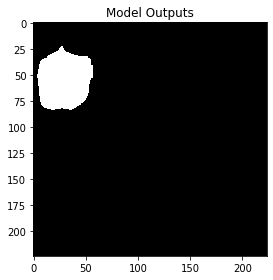

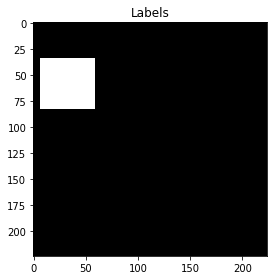

Avergae Score for batch 83.90668555377444


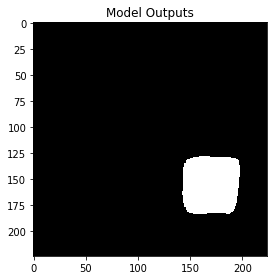

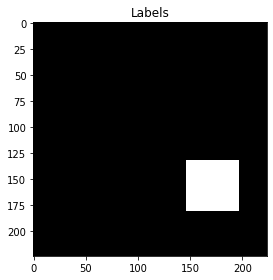

Avergae Score for batch 86.1445314957859


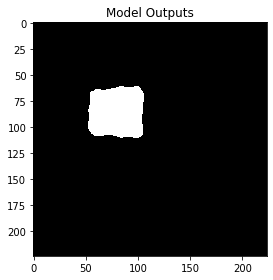

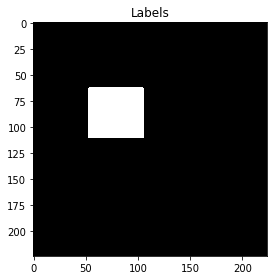

Avergae Score for batch 85.25699598365797


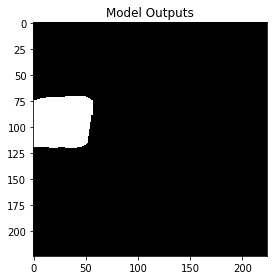

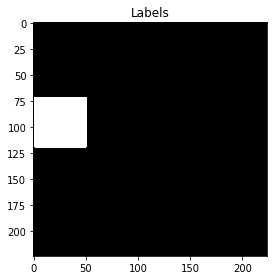

Avergae Score for batch 85.95140137579993


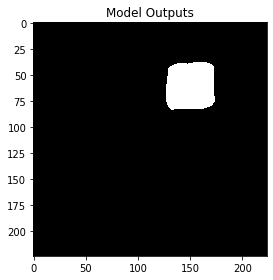

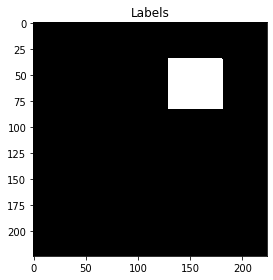

Avergae Score for batch 84.01453032144643


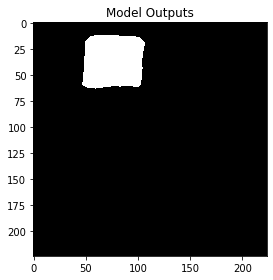

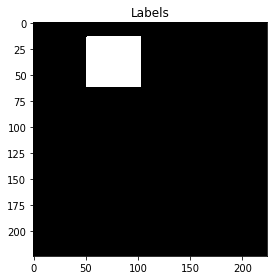

Avergae Score for batch 83.73986816353757


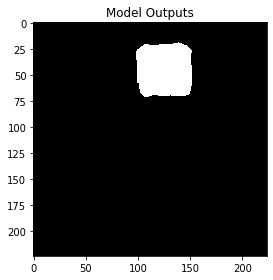

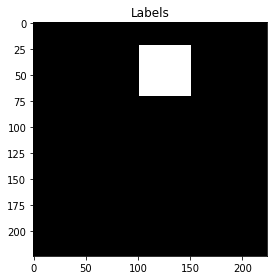

Avergae Score for batch 83.74569751690146


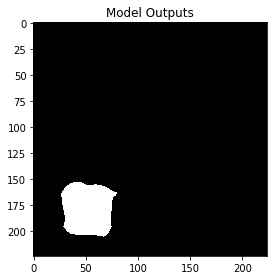

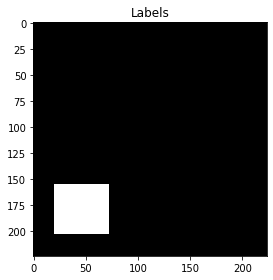

Avergae Score for batch 86.45763239688887


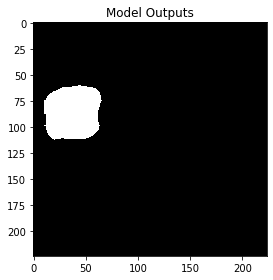

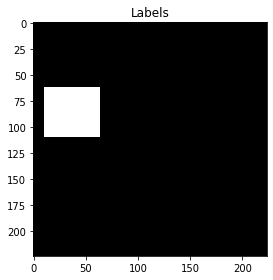

Avergae Score for batch 86.59092513074968


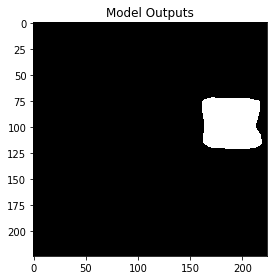

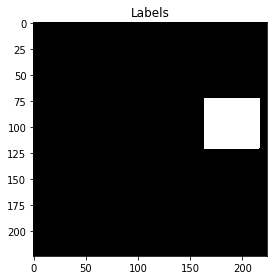

Avergae Score for batch 85.25407284400704


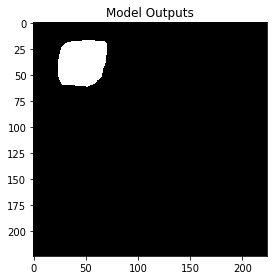

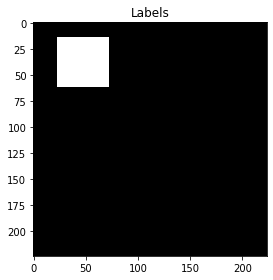

Avergae Score for batch 86.27537536389617


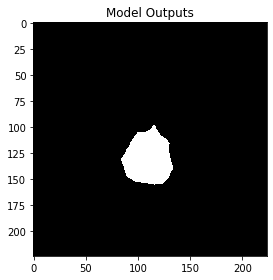

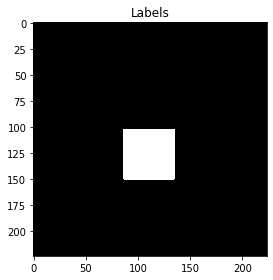

Avergae Score for batch 83.93872281865602


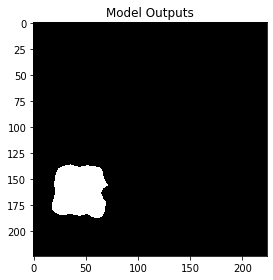

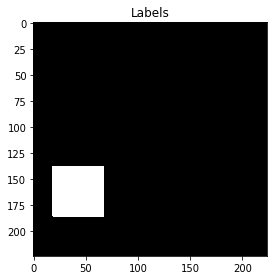

Avergae Score for batch 83.87210967357757


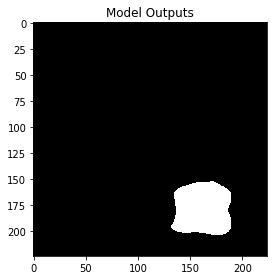

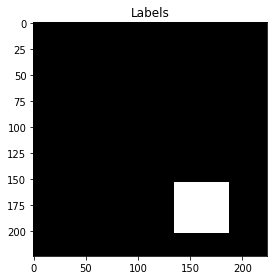

Avergae Score for batch 83.88769756152021


In [ ]:
from scipy.special import softmax
from sklearn.metrics import jaccard_score
import cv2 as cv
from scipy.special import expit, logit
model.eval()
valid_loss = 0
with torch.set_grad_enabled(False):
  for local_batch, local_labels in validation_generator:
    # Transfer to GPU
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    outputs=model(local_batch)['out']
    loss=calc_loss(outputs,local_labels)
    # print statistics
    valid_loss += loss.item()

    outputs=outputs.cpu().numpy()
    local_labels=local_labels.cpu().numpy()
    #print(outputs)
    for img in range(len(outputs)):
      #softmax 2.028568E-5
      imgArr=expit(outputs[img])
      #print(np.unique(b),"max",np.amax(b),"min",np.amin(b))
      #imgArr=softmax(outputs[img])
      imgmin=np.amin(imgArr)
      imgmax=np.amax(imgArr)
      thresh=imgmin+((imgmax-imgmin)*0.8)
      imgArr[imgArr >= thresh]=1
      imgArr[imgArr < thresh]=0
      
      outputs[img]=imgArr
    # with open("gdrive/My Drive/VASTECH-SSSD/testoutput.txt", "a") as myfile:
    #   for ele in outputs:
    #     for rrr in ele:
    #       for rr in rrr:

    #         myfile.write(str(rr))
    #       myfile.write("\n")
    

    show_img = (outputs[0][0]*255).astype(np.uint8)
    plt.figure()
    plt.title("Model Outputs")
    io.imshow(show_img)
    plt.show()
    show_img = (local_labels[0][0]*255).astype(np.uint8)
    plt.figure()
    plt.title("Labels")
    io.imshow(show_img)
    plt.show()
    # with open("gdrive/My Drive/VASTECH-SSSD/testlabel.txt", "a") as myfile:
    #   for ele in local_labels:
    #     for rrr in ele:
    #       for rr in rrr:

    #         myfile.write(str(rr))
    #       myfile.write("\n")
    # print("binary output",outputs,np.amax(outputs),np.amin(outputs))
    # print("1's: ",np.count_nonzero(outputs==1),"0's: ",np.count_nonzero(outputs==0))
    # print("labels",local_labels,np.amax(local_labels),np.amin(local_labels),np.unique(local_labels))
    # print("1's: ",np.count_nonzero(local_labels==1),"0's: ",np.count_nonzero(local_labels==0))
    batch_score_total=0
    for index_in_batch in range(len(outputs)):
      score=(jaccard_score(outputs[index_in_batch][0],local_labels[index_in_batch][0],average="micro")*100)
      #print(score)
      batch_score_total+=score
    print("Avergae Score for batch",batch_score_total/len(outputs))

    valid_loss = 0.0


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

min :  0.0 max:  1.0
min :  0 max:  255


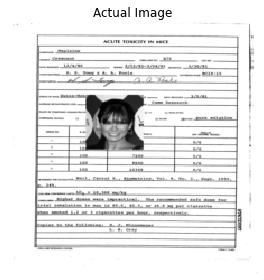

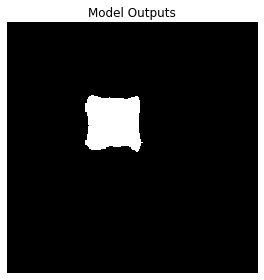

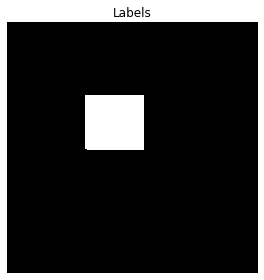

Avergae Score for batch 81.99515347294034
min :  0.0 max:  1.0
min :  0 max:  255


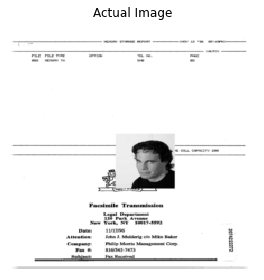

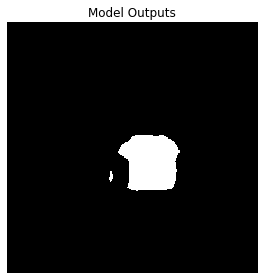

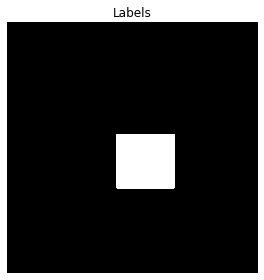

Avergae Score for batch 86.74533093294119
min :  0.0 max:  1.0
min :  0 max:  255


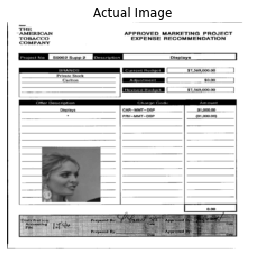

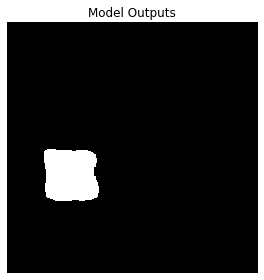

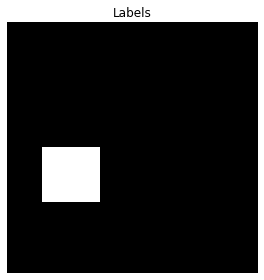

Avergae Score for batch 86.41808650788226
min :  0.0 max:  1.0
min :  0 max:  255


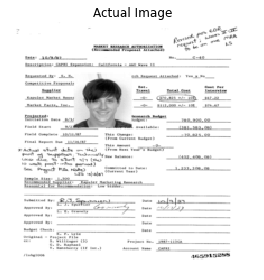

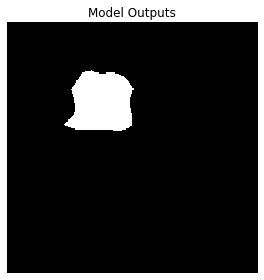

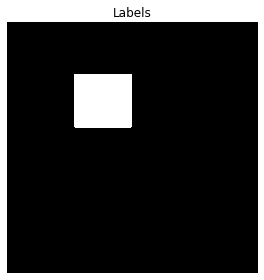

Avergae Score for batch 84.51065232699517
min :  0.0 max:  1.0
min :  0 max:  255


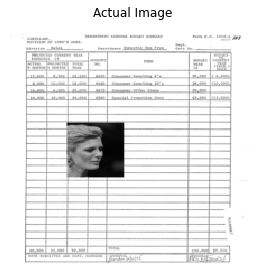

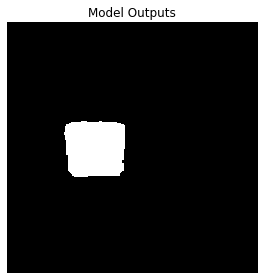

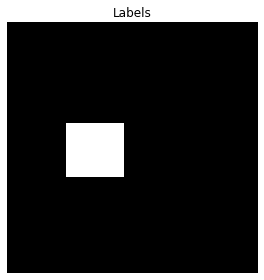

Avergae Score for batch 84.90392345555259
min :  0.0 max:  1.0
min :  0 max:  255


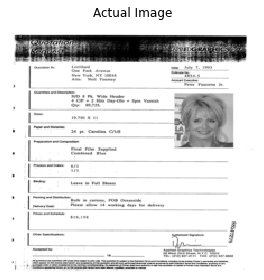

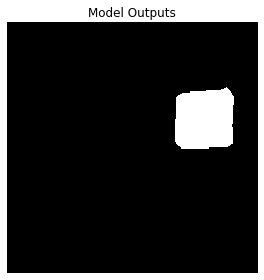

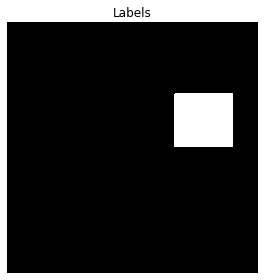

Avergae Score for batch 84.43920220363134
min :  0.0 max:  1.0
min :  0 max:  255


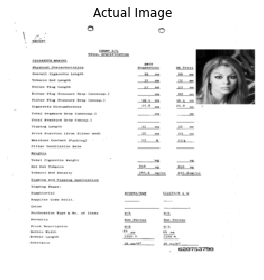

KeyboardInterrupt: ignored

In [82]:
from scipy.special import softmax
from sklearn.metrics import jaccard_score
import cv2 as cv
from scipy.special import expit, logit
model.eval()
valid_loss = 0
total_testing_score=0
test_count=0
with torch.set_grad_enabled(False):
  for local_batch, local_labels in testing_generator:
    # Transfer to GPU
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    outputs=model(local_batch)['out']
    loss=calc_loss(outputs,local_labels)
    # print statistics
    valid_loss += loss.item()

    outputs=outputs.cpu().numpy()
    local_labels=local_labels.cpu().numpy()
    #print(outputs)
    for img in range(len(outputs)):
      #softmax 2.028568E-5
      imgArr=expit(outputs[img])
      #print(np.unique(b),"max",np.amax(b),"min",np.amin(b))
      #imgArr=softmax(outputs[img])
      imgmin=np.amin(imgArr)
      imgmax=np.amax(imgArr)
      thresh=imgmin+((imgmax-imgmin)*0.8)
      imgArr[imgArr >= thresh]=1
      imgArr[imgArr < thresh]=0
      
      outputs[img]=imgArr

    local_batch=local_batch.cpu().numpy()
    local_batch[0][0]=local_batch[0][0]-np.amin(local_batch[0][0])
    local_batch[0][0]=local_batch[0][0]/np.amax(local_batch[0][0])
    print("min : ",np.amin(local_batch[0][0]),"max: ",np.amax(local_batch[0][0]))
    show_img = (local_batch[0][0]*255).astype(np.uint8)
    print("min : ",np.amin(show_img),"max: ",np.amax(show_img))

    plt.figure()
    plt.title("Actual Image")
    plt.axis("off")
    # if test_count < 5 :

    #   io.imsave('gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/o'+str(test_count)+'.png',show_img)
    io.imshow(show_img)
    plt.show()

    show_img = (outputs[0][0]*255).astype(np.uint8)
    plt.figure()
    plt.title("Model Outputs")
    plt.axis("off")
    # if test_count < 5 :

    #   io.imsave('gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/p'+str(test_count)+'.png',show_img)
    io.imshow(show_img)
    plt.show()
    show_img = (local_labels[0][0]*255).astype(np.uint8)
    plt.figure()
    plt.title("Labels")
    plt.axis("off")
    # if test_count < 5 :

    #   io.imsave('gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/l'+str(test_count)+'.png',show_img)
    io.imshow(show_img)
    plt.show()

    test_batch_score_total=0
    for index_in_batch in range(len(outputs)):
      score=(jaccard_score(outputs[index_in_batch][0],local_labels[index_in_batch][0],average="micro")*100)
      #print(score)
      test_batch_score_total+=score
    batchTest=test_batch_score_total/len(outputs)
    total_testing_score+=batchTest
    test_count+=1
    print("Avergae Score for batch",batchTest)

    valid_loss = 0.0
print("Total Testing MEAN IOU: ",total_testing_score/ test_count )

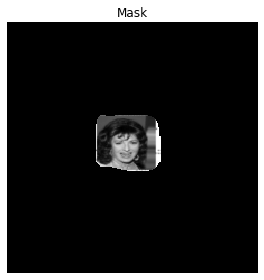

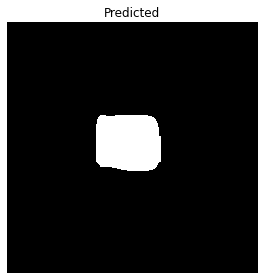

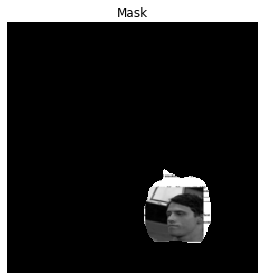

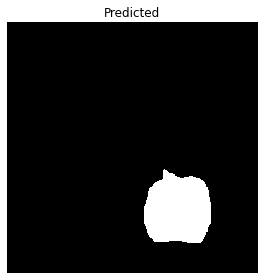

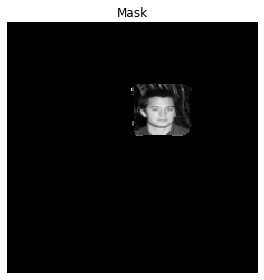

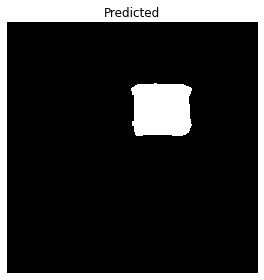

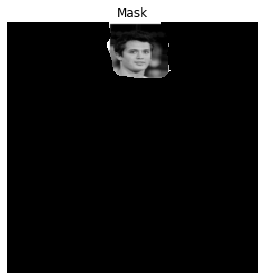

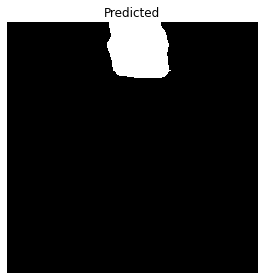

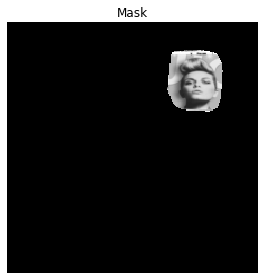

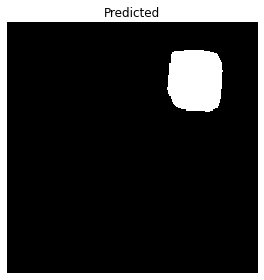

In [130]:
#masking
# count=0
for img in os.listdir('gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid'):
  if img[0]=='p':
    predicted=io.imread("gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/"+img)
    img="o"+img[1:]
    original=io.imread("gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/"+img)
    #print("predicted",np.unique(predicted),"original",np.unique(original),"predic length",len(predicted))
    canvas = np.zeros(predicted.shape)
    canvas.fill(0) 
    for row in range(len(predicted)):
       for column in range(len(predicted[row])):
         if predicted[row][column]==255:
           canvas[row][column]=original[row][column]
    show_img = (canvas).astype(np.uint8)

    # io.imsave('gdrive/My Drive/VASTECH-SSSD/Presentation/trained/sigmoid/m'+str(count)+'.png',show_img)
    count+=1
    plt.figure()
    plt.title("Mask")
    plt.axis("off")
    io.imshow(show_img)
    plt.show()
    show_img = (predicted).astype(np.uint8)
    plt.figure()
    plt.title("Predicted")
    plt.axis("off")
    io.imshow(show_img)
    plt.show()
         


In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open('gdrive/My Drive/VASTECH-SSSD/SuperImposed/Train/3994.png').convert('RGB')
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
print(output)
# Threshold model output and then display as we did above

tensor([[[0.0117, 0.0117, 0.0117,  ..., 0.0052, 0.0052, 0.0052],
         [0.0117, 0.0117, 0.0117,  ..., 0.0052, 0.0052, 0.0052],
         [0.0117, 0.0117, 0.0117,  ..., 0.0052, 0.0052, 0.0052],
         ...,
         [0.0017, 0.0017, 0.0017,  ..., 0.0334, 0.0334, 0.0334],
         [0.0017, 0.0017, 0.0017,  ..., 0.0334, 0.0334, 0.0334],
         [0.0017, 0.0017, 0.0017,  ..., 0.0334, 0.0334, 0.0334]]],
       device='cuda:0')


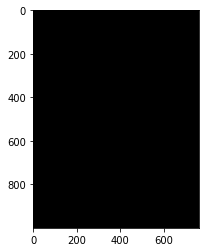

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()